In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/lyme-disease-rashes/RashData'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lyme-disease-rashes/RashData/RashData/Validation/Validation_2_Cases/Lyme_Negative/ringworm130.jpg
/kaggle/input/lyme-disease-rashes/RashData/RashData/Validation/Validation_2_Cases/Lyme_Negative/ringworm135.jpg
/kaggle/input/lyme-disease-rashes/RashData/RashData/Validation/Validation_2_Cases/Lyme_Negative/fixed drug reaction7.jpg
/kaggle/input/lyme-disease-rashes/RashData/RashData/Validation/Validation_2_Cases/Lyme_Negative/ringworm119.jpg
/kaggle/input/lyme-disease-rashes/RashData/RashData/Validation/Validation_2_Cases/Lyme_Negative/ringworm140.jpg
/kaggle/input/lyme-disease-rashes/RashData/RashData/Validation/Validation_2_Cases/Lyme_Negative/ringworm145.jpg
/kaggle/input/lyme-disease-rashes/RashData/RashData/Validation/Validation_2_Cases/Lyme_Negative/Pityriasis rosea rash7.jpg
/kaggle/input/lyme-disease-rashes/RashData/RashData/Validation/Validation_2_Cases/Lyme_Negative/ringworm147.jpg
/kaggle/input/lyme-disease-rashes/RashData/RashData/Validation/Validation_2_Cases/Ly

In [2]:
from numpy import asarray

from PIL import Image
# load the image
image = Image.open('/kaggle/input/lyme-disease-rashes/RashData/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans74.jpg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()
pixels = asarray(image)

JPEG
RGB
(1280, 820)


Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmp102qv8n5.PNG'


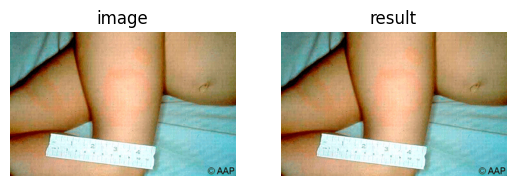

In [3]:
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(image)
ax0.axis('off')
ax0.set_title('image')
ax1.imshow(pixels)
ax1.axis('off')
ax1.set_title('result')
plt.show()

In [4]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

In [5]:
TRAIN_DIR = '/kaggle/input/lyme-disease-rashes/RashData/RashData/Train/Train_2_Cases'

TEST_DIR = '/kaggle/input/lyme-disease-rashes/RashData/RashData/Validation/Validation_2_Cases'

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input


HEIGHT = 300
WIDTH = 300

BATCH_SIZE = 8
class_list = ["class_1", "class_2"]
FC_LAYERS = [1024, 512, 256]
drop = 0.5
EPOCHS = 100



2024-06-21 15:36:01.231200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 15:36:01.231344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 15:36:01.375111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1
)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  rotation_range = 90,
                                  horizontal_flip = True,
                                  vertical_flip = False)

In [8]:
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size = (HEIGHT, WIDTH),
                                                    batch_size = BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size = (HEIGHT, WIDTH),
                                                  batch_size = BATCH_SIZE)

Found 357 images belonging to 2 classes.
Found 87 images belonging to 2 classes.


In [9]:
def build_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x)
        x = Dropout(drop)(x)
        
    predictions = Dense(num_classes, activation='softmax')(x)
    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

In [10]:
base_model_1 = ResNet50(weights='imagenet', include_top=False, input_shape=(HEIGHT,WIDTH,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [11]:
resnet50_model = build_model(base_model_1,
                                      dropout = drop,
                                      fc_layers = FC_LAYERS,
                                      num_classes = len(class_list))

In [12]:
from keras.optimizers import Adam

resnet50_model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

In [13]:
resnet50_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 306, 306,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 150, 150,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 150, 150,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 152, 152,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 75, 75,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 75, 75,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 75, 75,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 75, 75,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_3_c

 Total params: 233,960,578 (892.49 MB)

 Trainable params: 210,372,866 (802.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
history = resnet50_model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=20,
    validation_data=test_generator,
    
    shuffle=True
)


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.5213 - loss: 1.7955 - val_accuracy: 0.5862 - val_loss: 0.7005
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.4059 - loss: 1.8740 - val_accuracy: 0.5747 - val_loss: 0.7354
Epoch 3/100
 5/20 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.6347 - loss: 1.5109

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6249 - loss: 1.4799 - val_accuracy: 0.5747 - val_loss: 0.7441
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.6088 - loss: 1.3390 - val_accuracy: 0.6207 - val_loss: 0.6564
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.5338 - loss: 1.4801 - val_accuracy: 0.6322 - val_loss: 0.6241
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4844 - loss: 1.3913 - val_accuracy: 0.6092 - val_loss: 0.6015
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.6685 - loss: 1.1455 - val_accuracy: 0.6897 - val_loss: 0.5578
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.5686 - loss: 1.2553 - val_accuracy: 0.7241 - val_loss: 0.6118
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5715 - loss: 1.3621 - val_accuracy: 0.6782 - val_loss: 0.5591
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.5785 - loss: 1.2324 - val_accuracy: 0.8046 - val_loss: 0.

In [15]:
resnet50_model.save("Lyme_Detection.h5")